<a href="https://colab.research.google.com/github/Maxapelquist/Aim/blob/main/Semantic_Instance_Segmentation_Assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deadline: April 28th, 11:59 PM

# Semantic Segmentation and Instance Segmentation Assignment

Run the next cell ONLY IF YOU ARE USING COLAB:

In [ ]:
!gdown --id 1wzAVGdHnNepfBBDpRO2EmHiqqFfxpOGp
!unzip colab.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wzAVGdHnNepfBBDpRO2EmHiqqFfxpOGp
To: /content/colab.zip
100% 187k/187k [00:00<00:00, 124MB/s]
Archive:  colab.zip
   creating: segmentation_splits/
  inflating: segmentation_splits/train.txt  
  inflating: segmentation_splits/test.txt  
  inflating: segmentation_splits/val.txt  
  inflating: baboon.jpg              
  inflating: data_utils.py           
  inflating: download_datasets.sh    
  inflating: segmentation_nn.py      
  inflating: solver.py               
  inflating: vis_utils.py            


# A) Warm-Up (10 pts)



There are different interpolation types to upsample an image, such as nearest, linear, bilinear, bicubic... In this question, an original size baboon image, and a downsampled baboon image is provided. Interpolate the downsampled image with different modes, visualize them.

Typically, PSNR and SSIM metrics are used to evaluate the quality of a compressed/decompressed image. We can use them to measure the interpolation quality.


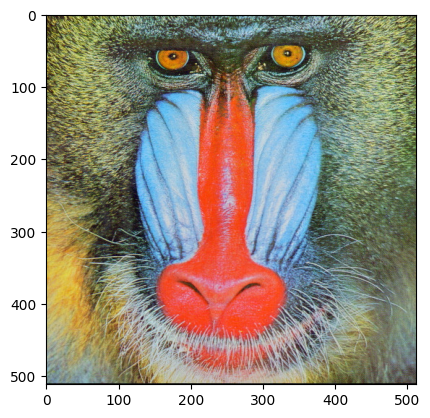

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('baboon.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

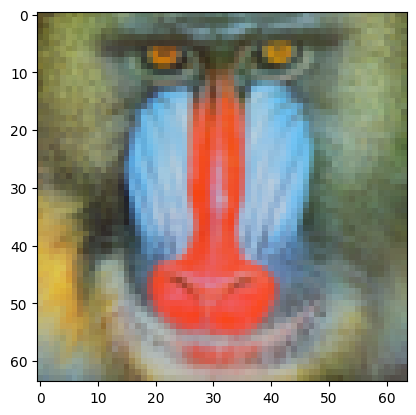

In [ ]:
from skimage import data, color, img_as_float
from skimage.transform import rescale, resize

img = img_as_float(img)
image_resized = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

plt.imshow(image_resized)

In [ ]:


import torch
import torch.nn.functional as F

img_tensor = torch.from_numpy(image_resized.transpose(2,0,1)).unsqueeze(0)

scale_factor = 8

# TODO: Use interpolation function torch.nn.functional to upsample images with different modes.
img_nearest = F.interpolate(img_tensor, scale_factor=scale_factor, mode='nearest')
img_bilinear = F.interpolate(img_tensor, scale_factor=scale_factor, mode='bilinear')
img_bicubic = F.interpolate(img_tensor, scale_factor=scale_factor, mode='bicubic')

# TODO: Convert images back to numpy.
img_nearest_np = img_nearest.squeeze(0).permute(1, 2, 0).numpy()
img_bilinear_np = img_bilinear.squeeze(0).permute(1, 2, 0).numpy()
img_bicubic_np = img_bicubic.squeeze(0).permute(1, 2, 0).numpy()


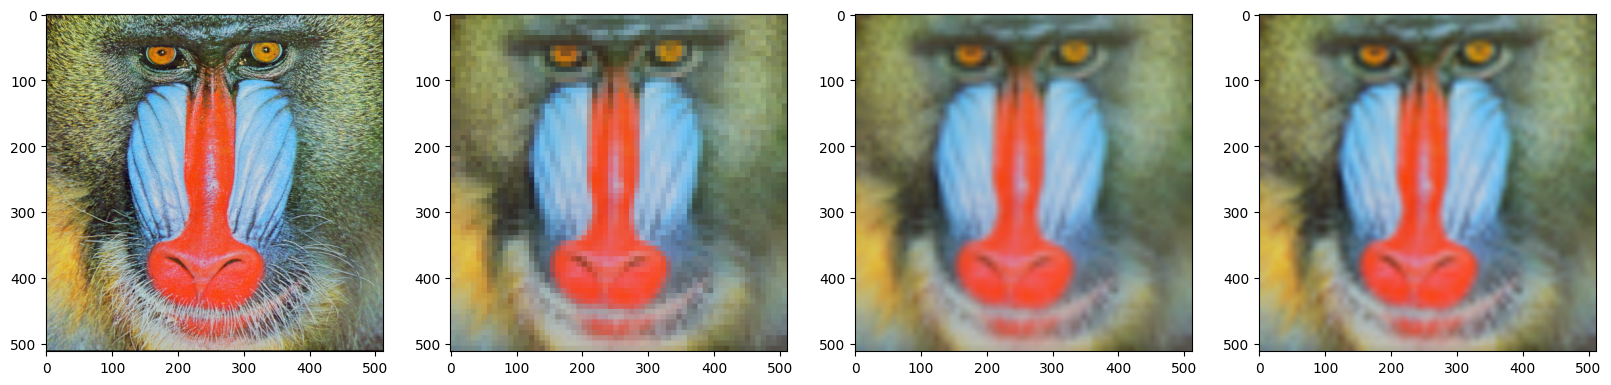

In [ ]:
# Visualization of images
f, axarr = plt.subplots(1,4,figsize=(20,20))
axarr[0].imshow(img)
axarr[1].imshow(img_nearest_np)
axarr[2].imshow(img_bilinear_np)
axarr[3].imshow(img_bicubic_np)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# TODO: calculate the PSNR and SSIM scores between original image and upsampled
# version. Do these scores align with the visualizations?

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Calculate the PSNR and SSIM scores between original image and upsampled version.
psnr_nearest = psnr(img, img_nearest_np)
ssim_nearest = ssim(img, img_nearest_np, multichannel=True)
psnr_bilinear = psnr(img, img_bilinear_np)
ssim_bilinear = ssim(img, img_bilinear_np, multichannel=True)
psnr_bicubic = psnr(img, img_bicubic_np)
ssim_bicubic = ssim(img, img_bicubic_np, multichannel=True)

print("Nearest Interpolation - PSNR:", psnr_nearest, "SSIM:", ssim_nearest)
print("Bilinear Interpolation - PSNR:", psnr_bilinear, "SSIM:", ssim_bilinear)
print("Bicubic Interpolation - PSNR:", psnr_bicubic, "SSIM:", ssim_bicubic)


<ipython-input-6-2283e9213ffe>:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nearest = ssim(img, img_nearest_np, multichannel=True)
<ipython-input-6-2283e9213ffe>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_bilinear = ssim(img, img_bilinear_np, multichannel=True)


Nearest Interpolation - PSNR: 19.107352326992938 SSIM: 0.43215310264632834
Bilinear Interpolation - PSNR: 19.217285842720976 SSIM: 0.4444279513220453
Bicubic Interpolation - PSNR: 19.419787077134643 SSIM: 0.45538129891364343


<ipython-input-6-2283e9213ffe>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_bicubic = ssim(img, img_bicubic_np, multichannel=True)


# B) Fully Convolutional Network for Semantic Segmentation (45 pts)

In this exercise, we will implement a neural network for semantic segmentation, and train and test the results with the provided dataset. As it would take a long time to train the whole network, we'll finetune the model by reusing a pretrained backbone model (eg. VGG16). You can influence from FCN, which is one of the first architectures proposed for semantic segmentation [1](https://arxiv.org/pdf/1411.4038.pdf).

We provide a skeleton code which should be filled in respectively. The dataloaders and utilization codes are also provided.


## MSRC-v2 Segmentation Dataset


We'll use the MSRC dataset for this exercise, which contains 591 images and 23 different semantic labels. The training is done on 443 images, validation on 74 and testing on 74 images. More info about the labels can be found on "info.html".

To get the dataset run the commands below to directly get them into the notebook.

In [ ]:
!wget http://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
!unzip msrc_objcategimagedatabase_v2.zip

--2024-04-24 11:47:45--  http://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.84.168.159, 2600:1407:3c00:ea3::317f, 2600:1407:3c00:e9b::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.84.168.159|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip [following]
--2024-04-24 11:47:45--  https://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
Connecting to download.microsoft.com (download.microsoft.com)|184.84.168.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115962745 (111M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v2.zip’

msrc_objcategimaged 100%[===================>] 110

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from segmentation_nn import SegmentationNN
from data_utils import SegmentationData, label_img_to_rgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = SegmentationData(image_paths_file='segmentation_splits/train.txt')
val_data = SegmentationData(image_paths_file='segmentation_splits/val.txt')

Train size: 443
Validation size: 74
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


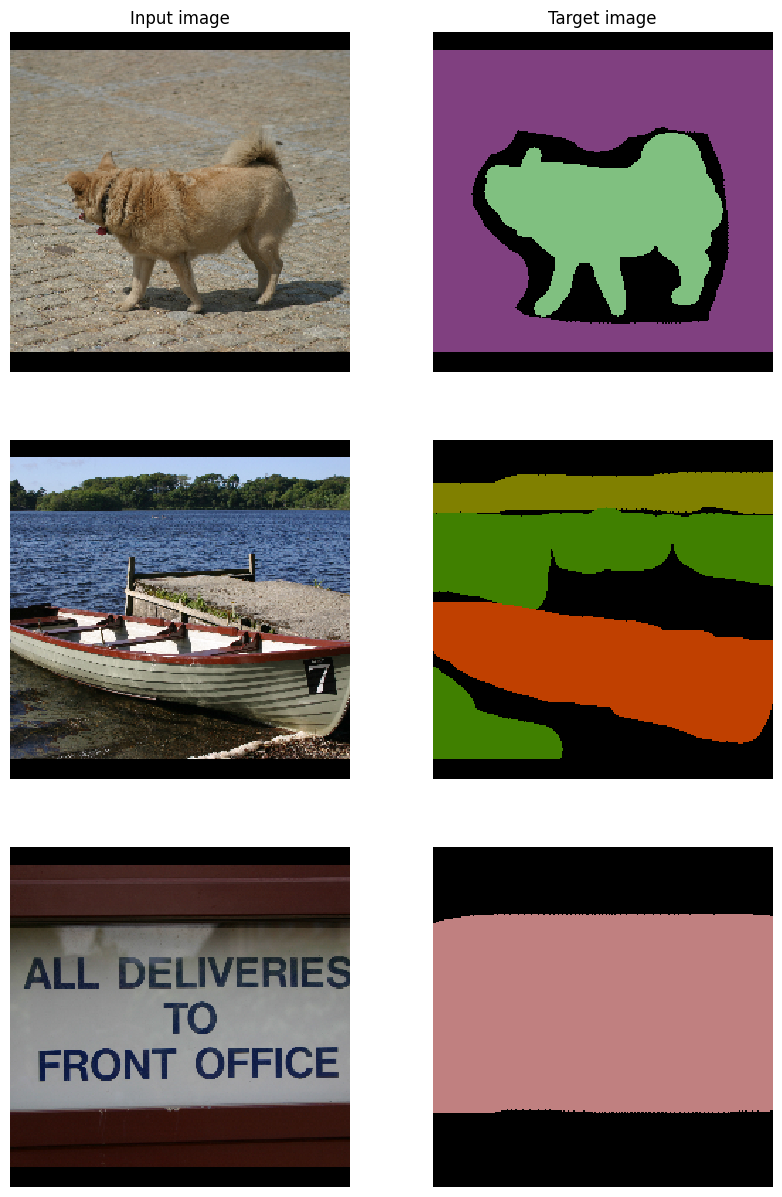

In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

## Part 1: Implement and Train the Network (25 pts)

Let's implement the neural network by filling up the necessary parts in `segmentation_nn.py`. It will take an input of size (N, C, H, W) and output (N, num_classes, H, W). As a pretrained backbone, you can use the VGG16 network from torchvision library, or any other backbone you wish. Start with a simple model where you take the feature layer from VGG, and introduce several layers which end up with segmentation predictions (FCN32 might be an example).


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

## This is provided for debugging! After implementing the network, put it into
## the "segmentation_nn.py" file.

class FCN(nn.Module):

    def __init__(self, num_classes=23):
        super(FCN, self).__init__()

        model = models.vgg16(pretrained= True)

    def forward(self, x):
      pass


For training, we provide the skeleton `solver.py` code. Fill in the given code for training and evaluation. The dataloaders are already provided, and you need to code up the optimization process. As for the loss, we can go with the typical `CrossEntropyLoss`. Note that there are some `unlabeled` classes in the dataset. These pixels should not be considered in the loss nor in the accuracy of the segmentation.

In [ ]:
from segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F

# Load the dataset and create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True, num_workers=4)

# Initialize the segmentation neural network model
model = SegmentationNN().cuda()

# Initialize the solver
solver = Solver()

# Train the model
num_epochs = 10
model = solver.train(model, train_loader, val_loader, num_epochs, log_nth=10)

# Save the trained model
model.save("segmentation_nn.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s]


START TRAIN.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Iteration 10/45] TRAIN loss: 2.875 acc: 0.148
[Iteration 20/45] TRAIN loss: 2.499 acc: 0.216
[Iteration 30/45] TRAIN loss: 2.146 acc: 0.289
[Iteration 40/45] TRAIN loss: 1.866 acc: 0.343


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/10] VAL loss: 0.921 acc: 0.505
[Iteration 10/45] TRAIN loss: 0.732 acc: 0.562
[Iteration 20/45] TRAIN loss: 0.679 acc: 0.557
[Iteration 30/45] TRAIN loss: 0.645 acc: 0.563
[Iteration 40/45] TRAIN loss: 0.618 acc: 0.555
[Epoch 2/10] VAL loss: 0.774 acc: 0.515
[Iteration 10/45] TRAIN loss: 0.378 acc: 0.582
[Iteration 20/45] TRAIN loss: 0.386 acc: 0.592
[Iteration 30/45] TRAIN loss: 0.365 acc: 0.599
[Iteration 40/45] TRAIN loss: 0.357 acc: 0.603
[Epoch 3/10] VAL loss: 0.551 acc: 0.566
[Iteration 10/45] TRAIN loss: 0.198 acc: 0.640
[Iteration 20/45] TRAIN loss: 0.191 acc: 0.624
[Iteration 30/45] TRAIN loss: 0.187 acc: 0.629
[Iteration 40/45] TRAIN loss: 0.191 acc: 0.636
[Epoch 4/10] VAL loss: 0.400 acc: 0.592
[Iteration 10/45] TRAIN loss: 0.130 acc: 0.660
[Iteration 20/45] TRAIN loss: 0.130 acc: 0.658
[Iteration 30/45] TRAIN loss: 0.132 acc: 0.652
[Iteration 40/45] TRAIN loss: 0.131 acc: 0.647
[Epoch 5/10] VAL loss: 0.347 acc: 0.603
[Iteration 10/45] TRAIN loss: 0.123 acc: 0.641
[

## Part 2: Test the Model (10 pts)

We will report the pixel accuracy and IoU metric for the trained model.
First, implement the Intersection over Union segmentation metric to measure the segmentation accuracy for the trained model.

You will use this function in the next cell.

In [ ]:
n_class = 23

def iou(pred, target):
    ious = []
    for cls in range(0, n_class):
        intersection = (pred == cls) & (target == cls)
        union = (pred == cls) | (target == cls)

        intersection = intersection.sum()
        union = union.sum()

        if union == 0: # if there is no ground truth, do not include in evaluation
            continue
        else:
            iou_cls = float(intersection) / union
            ious.append(iou_cls)

    return np.nanmean(ious)

Your model should result with a pixel accuracy of more than 60%.
The IoU should be more than 20%.

In [ ]:
test_data = SegmentationData(image_paths_file='segmentation_splits/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=1,
                                           shuffle=False,
                                           num_workers=1)

test_scores = []
total_ious = []
model.eval()

for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    # Retrieve the predictions
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # Calculate the test scores (mean accuracy of correctly classified labels)
    accuracy = torch.mean((predicted == targets).float())
    test_scores.append(accuracy.item())

    # Calculate IoU
    iou_score = iou(predicted.cpu().numpy(), targets.cpu().numpy())
    total_ious.append(iou_score)

print("Test accuracy: ", np.mean(test_scores))
print("Test IoU: ", np.nanmean(total_ious))


Test accuracy:  0.6210379312066613
Test IoU:  0.36334899003516447


## Part 3: Visualize the Results (5 pts)


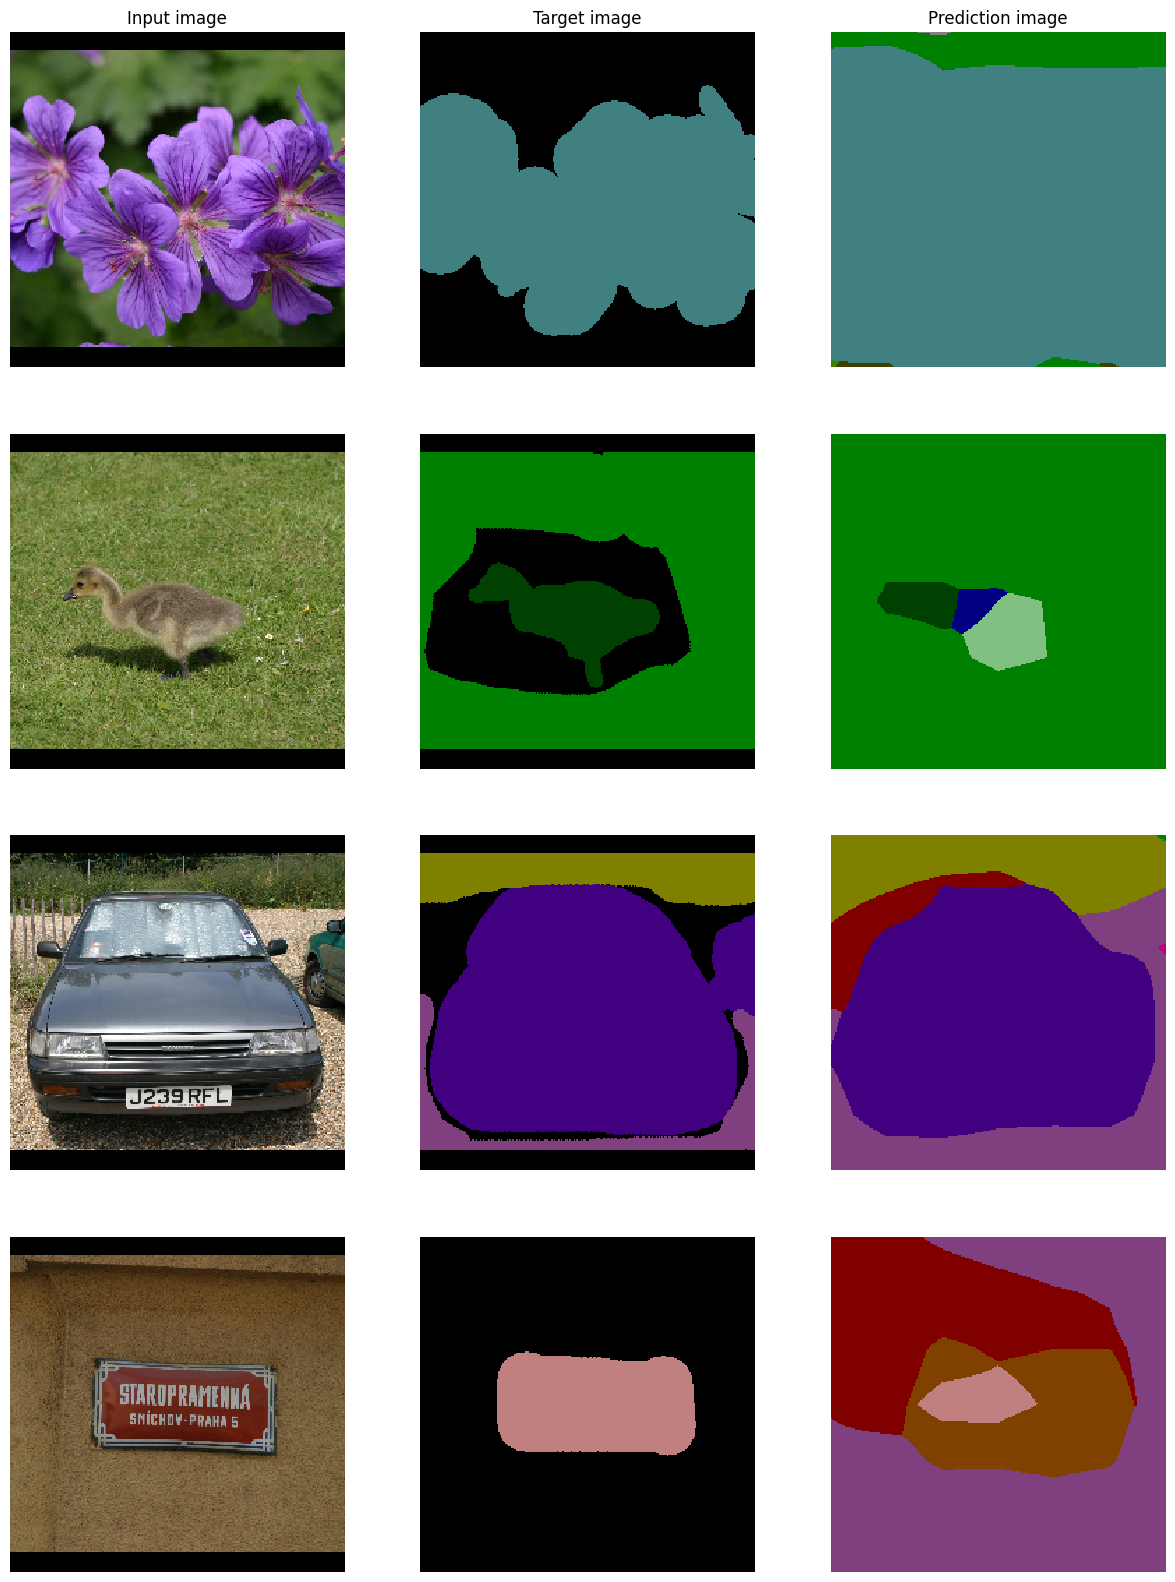

In [ ]:
import matplotlib.pyplot as plt

num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()

    # Retrieve the predictions
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    pred = pred.cpu().numpy()

    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))  # Corrected transpose using permute, okokokokk'?????????!!?!?!!??!
    if i == 0:
        plt.title("Input image")

    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")

plt.show()


## Part 4: Visualize Filter Weights (5 pts)
You can visualize the convolutional filters of the very first layer. Each kernel provides the structures of edges, corners and circles.


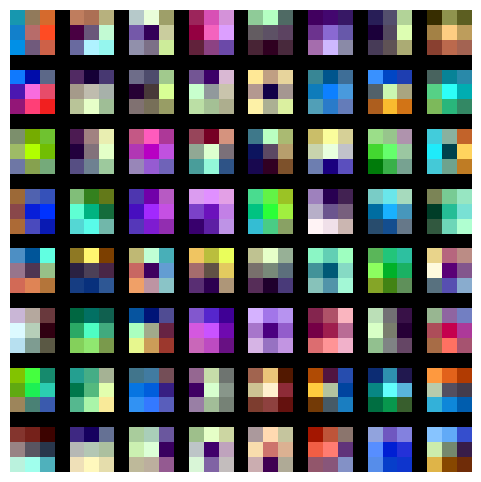

In [ ]:
from vis_utils import visualize_grid

# Get the parameters of the first convolutional layer
conv_params = model.features[0].weight.data.cpu().numpy()

# Visualize the convolutional filters
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()


# C) Object Detection to Instance Segmentation: Faster R-CNN to Mask R-CNN. (35 pts)

You have learnt about **Faster R-CNN** [12]  when object detection was covered. Remember that Faster R-CNN [12] predicts bounding boxes and class scores for potential objects in the image.

**Mask R-CNN** [6] adds an extra branch into Faster R-CNN [12], which also predicts segmentation masks for each instance.

<img src="https://pythonawesome.com/content/images/2018/07/Mask-RCNN.png" alt="Mask R-CNN" width="500">

You will implement this extra branch, train the model, test it, and visualize the results. You will use PennFudan [7] dataset.

In [1]:
pip install numpy==1.23 # needed this in order to get it to work without numpy errors.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.0 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.


In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-93pn5jm5
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-93pn5jm5
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375503 sha256=cde4b5f21177fcda6ce48a93e1dd0b680361e063aae1cb46bf6f4729e35680db
  Stored in directory: /tmp/pip-ephem-wheel-cache-daq50lmy/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [2]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2024-04-24 16:58:58--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  26.4MB/s    in 1.9s    

2024-04-24 16:59:01 (26.4 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2024-04-24 16:59:01--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-04-24 16:59:01--
Total wall clock time: 2.3s
Downloaded: 1 files, 51M in 1.9s (26.4 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

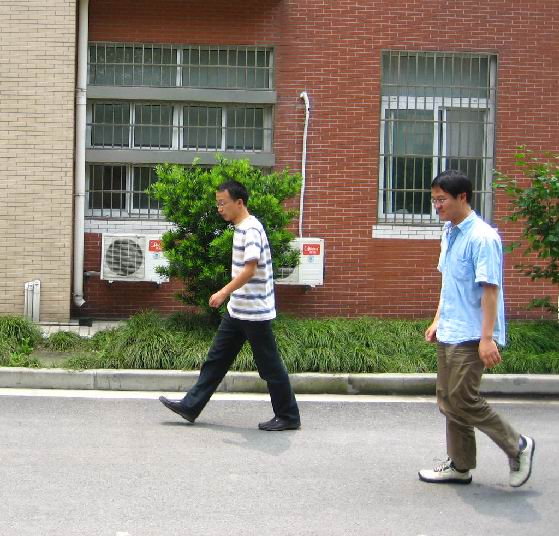

In [3]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

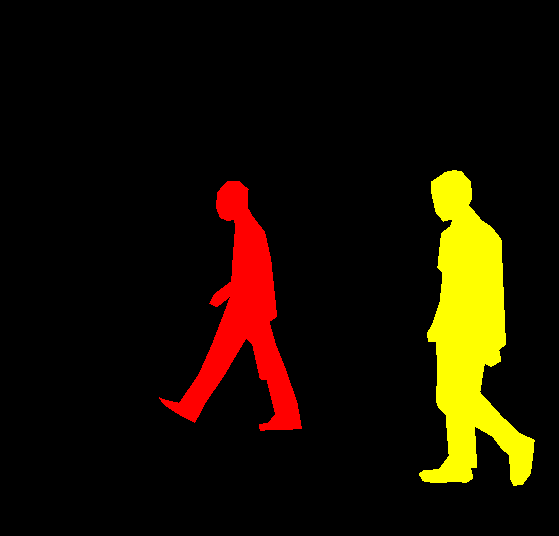

In [4]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask = mask.convert("P")

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

You can find how dataset for PennFudan [7] looks like below.
## Question 1 (7.5 pts)
Given masks in an image in the dataset, find the bounding box coordinates of a mask.

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            ##################################################################
            ###                      YOUR CODE STARTS                      ###
            ##################################################################
            # Calculate bounding box coordinates for each mask in the input masks
            object_rows, object_cols = np.where(masks[i])

            # Find the minimum and maximum row and column indices to get the bounding box coordinates
            min_row, max_row = np.min(object_rows), np.max(object_rows)
            min_col, max_col = np.min(object_cols), np.max(object_cols)

            # Append the bounding box coordinates to the list 'boxes'
            boxes.append([min_col, min_row, max_col, max_row])
            ##################################################################
            ###                       YOUR CODE ENDS                       ###
            ##################################################################

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 497462, done.
remote: Counting objects: 100% (11072/11072), done.
remote: Compressing objects: 100% (654/654), done.
remote: Total 497462 (delta 10444), reused 11008 (delta 10398), pack-reused 486390
Receiving objects: 100% (497462/497462), 965.22 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (463679/463679), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


## Question 2 (5 pts)
Implement transformations for images. (Keeping in mind our task and dataset, use appropriate data augmentations)

In [8]:
#!pip install --upgrade torch torchvision

##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
# TODO: train_transform bör konvertera bilden till en PyTorch-tensor och sedan tillämpa
# minst två ytterligare transformationer för dataaugmentering
from engine import train_one_epoch, evaluate
import utils
import torchvision.transforms as T

class ApplyTransformToBatch:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img, target):
        # Apply the transform to the image
        img = self.transform(img)
        # You can modify this part if your target also needs transformation
        # For now, we'll assume the target doesn't need transformation
        return img, target

def train_transform():
    base_transform = T.Compose([
        T.ToTensor(),  # Konvertera till PyTorch-tensor
        T.RandomHorizontalFlip(p=0.5),  # Horisontell spegling med 50% sannolikhet
    ])
    return ApplyTransformToBatch(base_transform)



# TODO: test_transform should convert image into a PyTorch tensor

def test_transform():
    base_transform = T.Compose([
        T.ToTensor()
    ])
    return ApplyTransformToBatch(base_transform)



##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################


In [9]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', train_transform())
dataset_test = PennFudanDataset('PennFudanPed', test_transform())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Question 3 (10 pts)
<img src="https://vipulvaibhaw.files.wordpress.com/2019/04/screenshot-2019-04-20-at-8.34.16-am.png?w=1100" alt="Mask R-CNN detailed" width="500">

Mask R-CNN [6] proposes two heads for mask detection. We have implemented below the one on the right (w/ FPN) on top of a pretrained Faster R-CNN [12]. You can find Figure 4 in [6] for the details of the network.

In [10]:
import torchvision
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#Defining ROI Align.
mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=14,
                sampling_ratio=2)

#Adding head
mask_head = nn.Sequential(
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
        )

#Adding predictor
mask_predictor = nn.Sequential(
          nn.ConvTranspose2d(256, 256, 2, 2, 0),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 91, 1, 1, 0)
        )


my_mask = fasterrcnn
my_mask.roi_heads.mask_roi_pool = mask_roi_pool
my_mask.roi_heads.mask_head = mask_head
my_mask.roi_heads.mask_predictor = mask_predictor

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = my_mask
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Construct an optimizer.

In [55]:
params = [p for p in model.parameters() if p.requires_grad]

import torch.optim as optim

optimizer = optim.AdamW(params, lr=0.001)


In [56]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 25 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [ 0/60]  eta: 0:01:23  lr: 0.000018  loss: 0.8573 (0.8573)  loss_classifier: 0.0963 (0.0963)  loss_box_reg: 0.1402 (0.1402)  loss_mask: 0.5781 (0.5781)  loss_objectness: 0.0146 (0.0146)  loss_rpn_box_reg: 0.0282 (0.0282)  time: 1.3870  data: 0.5488  max mem: 3687
Epoch: [0]  [10/60]  eta: 0:00:33  lr: 0.000187  loss: 0.7913 (0.8034)  loss_classifier: 0.0806 (0.0900)  loss_box_reg: 0.0957 (0.1097)  loss_mask: 0.5781 (0.5729)  loss_objectness: 0.0134 (0.0149)  loss_rpn_box_reg: 0.0130 (0.0160)  time: 0.6686  data: 0.0595  max mem: 3687
Epoch: [0]  [20/60]  eta: 0:00:25  lr: 0.000357  loss: 0.8165 (0.8477)  loss_classifier: 0.0845 (0.0998)  loss_box_reg: 0.1046 (0.1238)  loss_mask: 0.5813 (0.5798)  loss_objectness: 0.0144 (0.0254)  loss_rpn_box_reg: 0.0151 (0.0189)  time: 0.6041  data: 0.0105  max mem: 3687
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.000526  loss: 0.8538 (0.8535)  loss_classifier: 0.0972 (0.1073)  loss_box_reg: 0.1203 (0.1261)  loss_mask: 0.5813 (0.5755)  loss_ob

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.001000  loss: 0.8781 (0.9114)  loss_classifier: 0.1096 (0.1290)  loss_box_reg: 0.1131 (0.1271)  loss_mask: 0.5842 (0.5777)  loss_objectness: 0.0190 (0.0565)  loss_rpn_box_reg: 0.0162 (0.0211)  time: 0.5663  data: 0.0097  max mem: 3687
Epoch: [0] Total time: 0:00:36 (0.6119 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:29  model_time: 0.3535 (0.3535)  evaluator_time: 0.0047 (0.0047)  time: 0.5918  data: 0.2318  max mem: 3687
Test:  [49/50]  eta: 0:00:00  model_time: 0.2438 (0.2342)  evaluator_time: 0.0062 (0.0062)  time: 0.2648  data: 0.0063  max mem: 3687
Test: Total time: 0:00:12 (0.2597 s / it)
Averaged stats: model_time: 0.2438 (0.2342)  evaluator_time: 0.0062 (0.0062)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ I

In [47]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

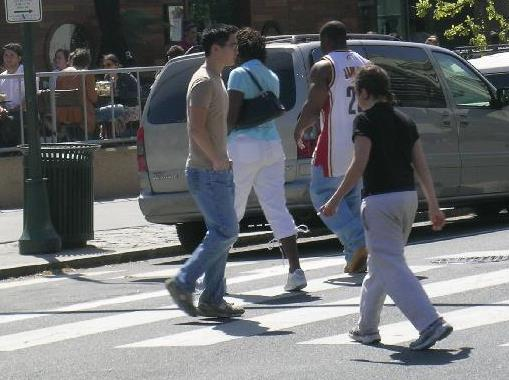

In [48]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

## Question 4 (5 pts)
Given mask of an object, colorize the mask.

## Question 5 (7.5 pts)
Visualize the image, masks, and bounding boxes. You can expect non-perfect masks.  

Optional: If you want better masks, change your training strategy! (changing # of epochs, different optimizer etc.)

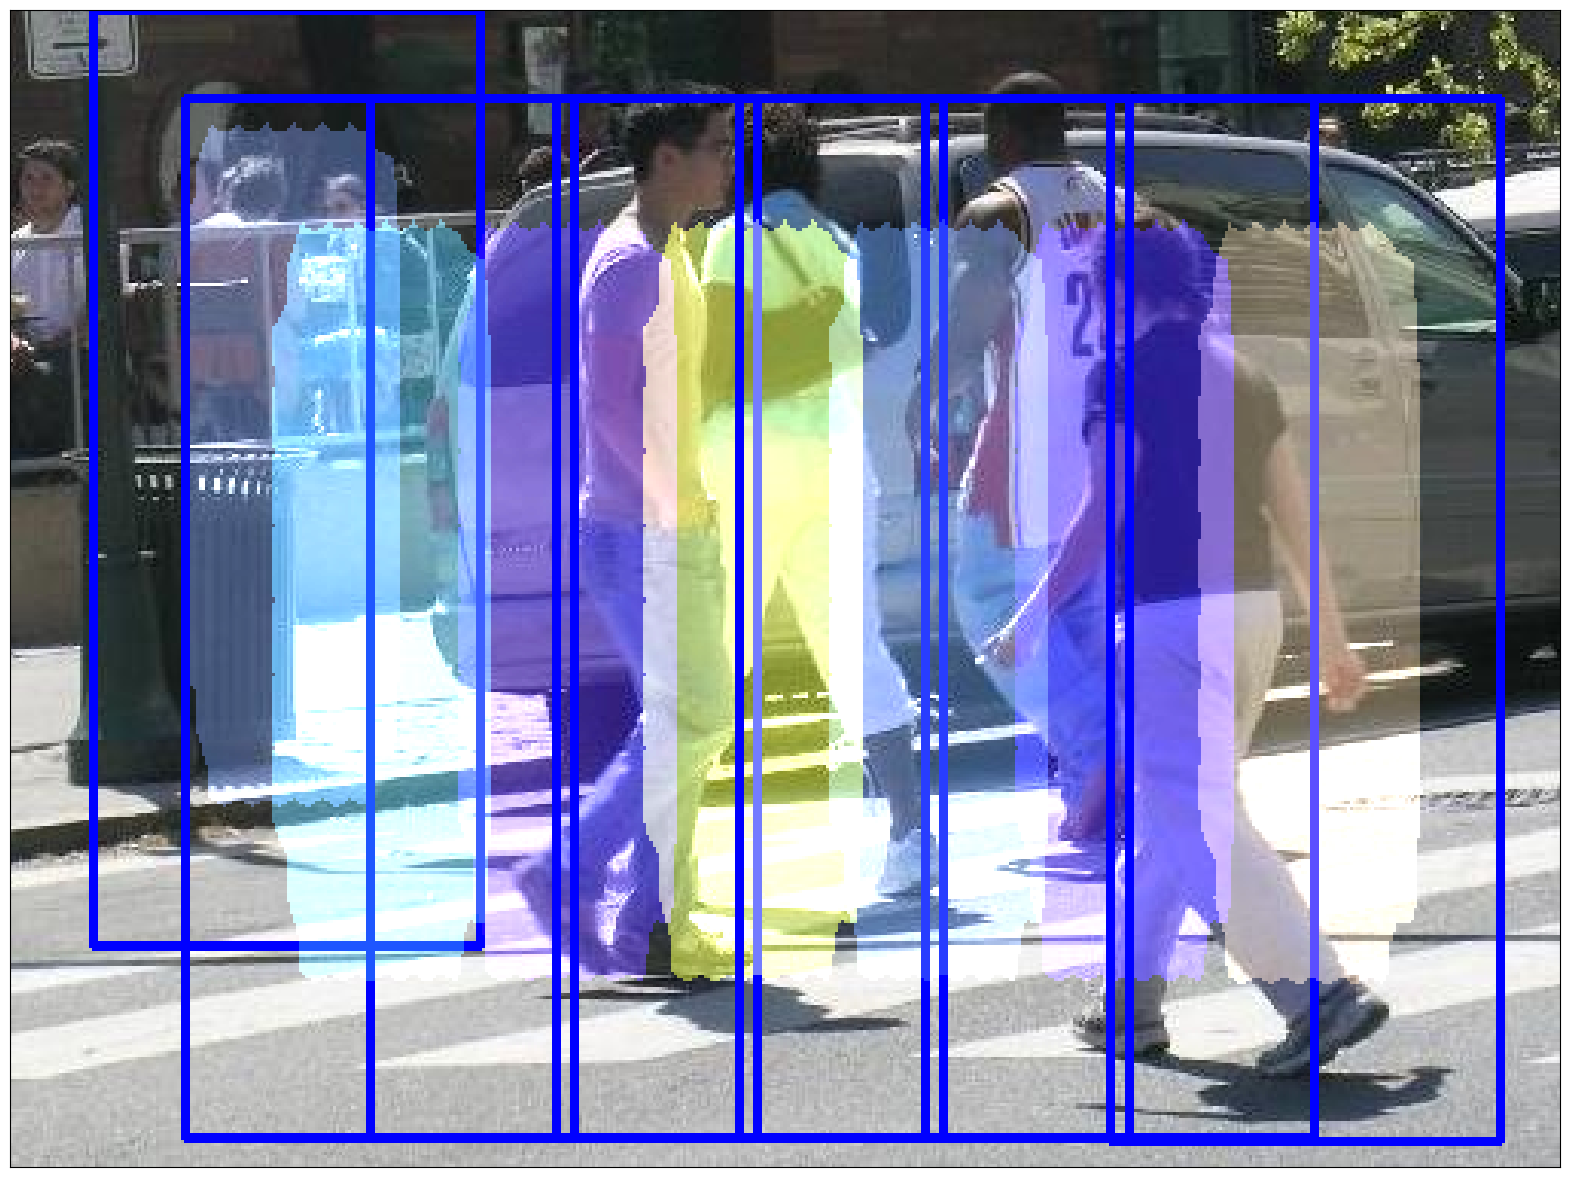

In [52]:
import numpy as np


def get_coloured_mask(mask):
    # Define a threshold to filter out noise. Only values above this are considered part of the object.
    threshold = 149  # Assuming mask is in grayscale [0, 255], modify as needed based on your data range.

    # Apply the threshold to create a binary mask
    binary_mask = mask > threshold

    # Choose a random color for the mask; each channel will have values between 0 and 255
    color = np.random.randint(0, 256, size=3)

    # Initialize the coloured mask with zeros. Shape (3, H, W)
    coloured_mask = np.zeros((3, mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # Assign the color to the mask where the binary mask is True
    for i in range(3):
        coloured_mask[i][binary_mask] = color[i]

    return coloured_mask



import cv2
import matplotlib.pyplot as plt
import numpy as np

def vis_instance(img, prediction):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()  # Convert tensor image to numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert image from RGB to BGR for OpenCV

    scores = prediction[0]['scores'].tolist()
    for i in range(len(scores)):
        if scores[i] > 0.4:  # Filter out low confidence detections
            box = prediction[0]['boxes'][i].cpu().numpy().astype(int)
            mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
            rgb_mask = get_coloured_mask(mask)
            rgb_mask = rgb_mask.transpose(1, 2, 0)  # Change shape from (3, H, W) to (H, W, 3)

            # Create a mask where the colored mask is placed
            full_mask = np.zeros_like(img)
            full_mask[box[1]:box[3], box[0]:box[2]] = rgb_mask[box[1]:box[3], box[0]:box[2]]

            # Overlay mask
            img = cv2.addWeighted(img, 1.0, full_mask, 0.5, 0)

            # Draw rectangle
            color = (255, 0, 0)  # Blue color in BGR
            thickness = 2
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, thickness)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image back to RGB for matplotlib
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

vis_instance(img, prediction)

##TEST NR 2, OTHER OPTIMIZER

In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

"""         transforms.ToTensor(),
            transforms.RandomHorizontalFlip(0.5),
            Resize_fixed(224,training=False)
            # transforms.ColorJitter(0.05, 0.05, 0.05, 0.05)
"""

'         transforms.ToTensor(),\n            transforms.RandomHorizontalFlip(0.5),\n            Resize_fixed(224,training=False)\n            # transforms.ColorJitter(0.05, 0.05, 0.05, 0.05)\n'

In [13]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 25 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [15]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

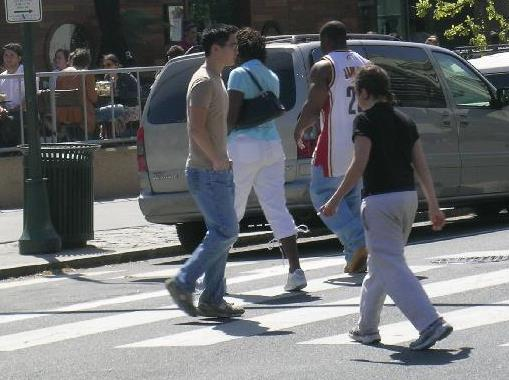

In [16]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

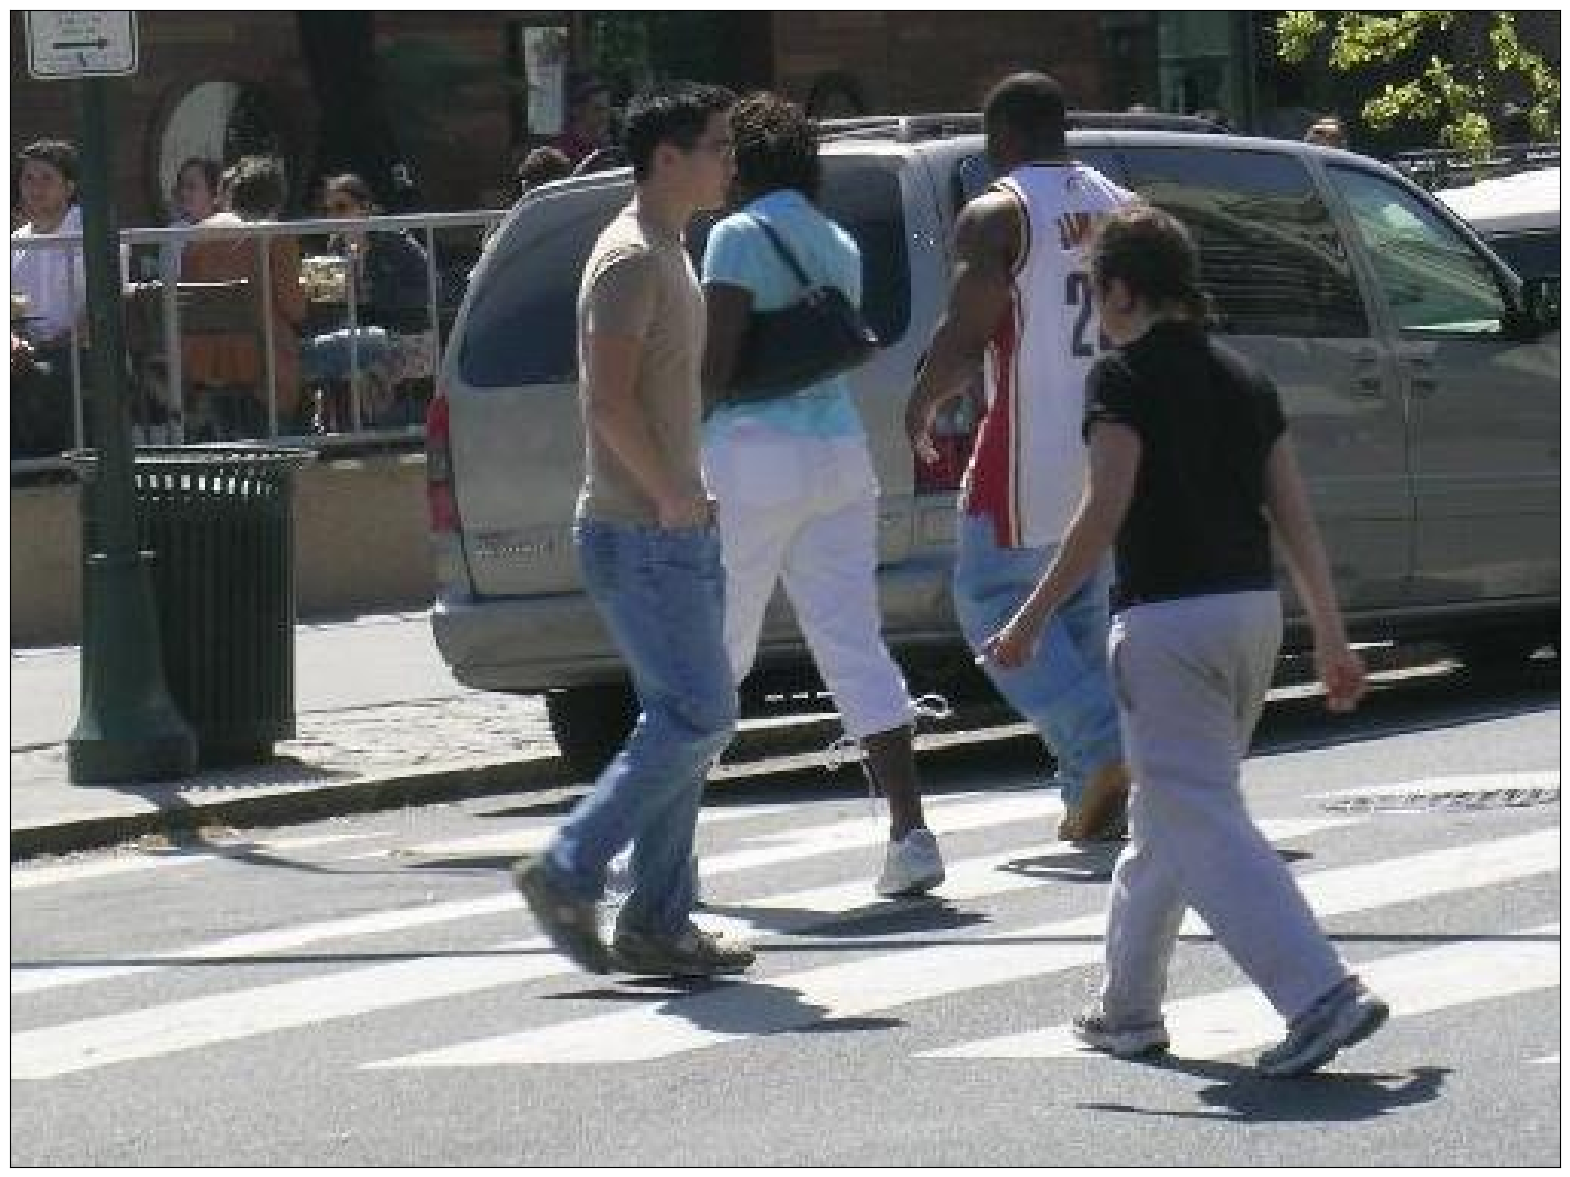

In [54]:
import numpy as np


def get_coloured_mask(mask):
    # Define a threshold to filter out noise. Only values above this are considered part of the object.
    threshold = 125  # Assuming mask is in grayscale [0, 255], modify as needed based on your data range.

    # Apply the threshold to create a binary mask
    binary_mask = mask > threshold

    # Choose a random color for the mask; each channel will have values between 0 and 255
    color = np.random.randint(0, 256, size=3)

    # Initialize the coloured mask with zeros. Shape (3, H, W)
    coloured_mask = np.zeros((3, mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # Assign the color to the mask where the binary mask is True
    for i in range(3):
        coloured_mask[i][binary_mask] = color[i]

    return coloured_mask



import cv2
import matplotlib.pyplot as plt
import numpy as np

def vis_instance(img, prediction):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()  # Convert tensor image to numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert image from RGB to BGR for OpenCV

    scores = prediction[0]['scores'].tolist()
    for i in range(len(scores)):
        if scores[i] > 0.70:  # Filter out low confidence detections
            box = prediction[0]['boxes'][i].cpu().numpy().astype(int)
            mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
            rgb_mask = get_coloured_mask(mask)
            rgb_mask = rgb_mask.transpose(1, 2, 0)  # Change shape from (3, H, W) to (H, W, 3)

            # Create a mask where the colored mask is placed
            full_mask = np.zeros_like(img)
            full_mask[box[1]:box[3], box[0]:box[2]] = rgb_mask[box[1]:box[3], box[0]:box[2]]

            # Overlay mask
            img = cv2.addWeighted(img, 1.0, full_mask, 0.5, 0)

            # Draw rectangle
            color = (255, 0, 0)  # Blue color in BGR
            thickness = 2
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, thickness)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image back to RGB for matplotlib
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

vis_instance(img, prediction)

## D) Bird's Eye-View Questions (10 pts)

## Question 1 (5 pts)
Why is the bird's eye view representation the most common representation in autonomous driving? What are the advantages and disadvantages compared to using a representation in pixel space? Discuss this.

You can check the Introduction parts of the following papers: [SimpleBEV [14]](https://arxiv.org/pdf/2206.07959.pdf), [BEVFormer [15]](https://arxiv.org/pdf/2203.17270.pdf )

**Answer:**

#Advantages of BEV representation:

Spatial Clarity: BEV provides a top-down view of the environment, allowing for clear spatial understanding of the surroundings. This perspective makes it easier to perceive distances, sizes, and orientations of objects, which is crucial for tasks such as navigation and obstacle detection.

Scale Consistency: BEV representation maintains consistent scale across the entire field of view. This consistency simplifies the interpretation of distances and sizes of objects, regardless of their position in the image.

Task Relevance: BEV representation is well-suited for driving-related tasks such as navigation, obstacle detection, and moving-obstacle forecasting. These tasks often require understanding the spatial layout of the environment, which BEV efficiently captures.

Robustness: BEV representation can be more robust to variations in lighting conditions and camera perspectives compared to pixel space representations. This robustness is crucial for real-world deployment where environmental conditions may vary.

#Disadvantages of BEV representation:

Loss of Detailed Information: BEV representation typically abstracts away detailed pixel-level information present in the original images. This loss of detail can impact tasks that rely on fine-grained visual features, such as object recognition or classification.

Complexity of Transformation: Generating BEV representation often requires complex transformations from multiple camera views. These transformations may introduce computational overhead and require additional processing steps compared to working directly with pixel space representations.

Depth Estimation Dependency: Some methods for generating BEV representations rely on accurate depth estimation, which may be challenging, especially in dynamic environments with moving objects or changing lighting conditions. Inaccurate depth estimation can lead to errors in BEV representation.

## Question 2 (5 pts)

- When forming a Bird's Eye View (BEV) representation of a scene from camera images, what are we trying to recover?
  
  **Answer**:
  When forming a Bird's Eye View (BEV) representation of a scene from camera images, we are trying to recover a top-down view of the environment surrounding the vehicle. This representation aims to capture the spatial layout of objects, obstacles, and the road surface in the scene. Essentially, we are attempting to reconstruct the 3D structure of the environment as it would appear from above, providing a comprehensive understanding of the surrounding space in terms of distances, sizes, and orientations of objects relative to the vehicle's position.

- What are the main challenges of BEV methods?
 In which cases these methods likely to fail?

  You can refer to Introduction and Related Work parts of the papers.

  [SimpleBEV [14]](https://arxiv.org/pdf/2206.07959.pdf), [BEVFormer [15]](https://arxiv.org/pdf/2203.17270.pdf), [PointBEV [16]](https://arxiv.org/pdf/2312.00703.pdf)


  **Answer**:

##The main challenges of BEV methods include:

Depth Estimation and 3D Geometry: Generating BEV maps involves estimating depth and understanding the 3D geometry of the scene, which can be challenging and computationally intensive.

Interpretability: Some BEV methods lack interpretability as the mapping from perspective view to BEV is implicit, making it difficult to understand the reasoning behind the representations.

Precise Depth Estimation: Precise depth estimation is essential for accurately projecting image features to their corresponding 3D locations in the BEV representation. Inaccurate depth estimation can lead to errors in the final representation.

Complexity of Transformation: Methods that rely on complex transformations from multiple camera views may introduce computational overhead and require additional processing steps.

##BEV methods are likely to fail in cases where:

Depth Estimation is Poor: If depth estimation is inaccurate or unreliable, it can lead to errors in projecting image features onto the BEV representation.

Non-Planar Scenes: Methods based on homography-based unprojection may produce poor results in non-planar scenes where the ground plane is not well-defined.

Sparse or Noisy Radar Data: BEV methods that incorporate radar data may fail if the radar data is too sparse or noisy to provide useful information for semantic labeling.


# References

[1] J. Long, E. Shelhamer, and T. Darrell. Fully Convolutional Networks for Semantic Segmentation. CVPR, 2015.

[2] V. Badrinarayanan, A. Kendall, and R. Cipolla. Fully Convolutional Networks for Semantic Segmentation. PAMI, 2017.

[3] O. Ronneberger, P. Fischer, and T. Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. MICCAI, 2015.

[4] Checkerboard artifacts [https://distill.pub/2016/deconv-checkerboard/]

[5] A survey of loss functions for semantic segmentation [https://arxiv.org/pdf/2006.14822.pdf].

[6] K. He, G. Gkioxari, P. Dollar, and R. Girshick. Mask R-CNN. ICCV, 2017.   

[7] https://www.cis.upenn.edu/~jshi/ped_html/  

[8] J. Dai, K. He, and J. Sun. Instance-aware Semantic Segmentation via Multi-task Network Cascades. CVPR, 2016.  

[9] R. Girshick. Fast R-CNN. ICCV, 2015.   

[10] J. Long, E. Shelhamer, and T. Darrell. Fully convolutional networks for semantic segmentation. CVPR, 2015.   

[11] D. Bolya, C. Zhou, F. Xiao, Y. Jae Lee. YOLACT: Real-time Instance Segmentation. ICCV, 2019

[12] Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. S. Ren, K. He, R. Girshick, J. Sun. NIPS, 2015    

[13] https://d2l.ai/chapter_computer-vision/bounding-box.html#bounding-box

[14] Harley, Adam W., et al. "Simple-bev: What really matters for multi-sensor bev perception?." 2023 IEEE International Conference on Robotics and Automation (ICRA). IEEE, 2023.

[15] Li, Zhiqi, et al. "Bevformer: Learning bird’s-eye-view representation from multi-camera images via spatiotemporal transformers." European conference on computer vision. Cham: Springer Nature Switzerland, 2022.

[16] Chambon, Loick, et al. "PointBeV: A Sparse Approach to BeV Predictions." arXiv preprint arXiv:2312.00703 (2023).